In [2]:
%matplotlib inline
import matplotlib.pyplot as plt


import os
import itertools
import json
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
import collections
from collections import Counter
import scipy
import time
import re

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition.pca import PCA


import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import gensim


/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


#### TODOs for data cleaning:

1. remove square brackets
2. make everything lower case


## Overview

This notebook is used to prepare the text to then be used for NLP analysis. Mostly it is to tokenise the full text column.

This specific instance of the notebook will be applied to the analysis of NOS


In [3]:
# flatten lists of lists
def flatten_lol(t):
    return list(itertools.chain.from_iterable(t))
flatten_lol([[1,2],[3],[4,5,6]])

[1, 2, 3, 4, 5, 6]

In [4]:
#These two functions are useful for analysing bi and tri-grams with w2v models in gensim

def convert_to_undersc(skill):
    '''
    convert spaces in skill phrases into underscores to use with trained
    w2v model.
    '''
    if len(skill.split(' ')) >1:
        new_i = '-'.join(skill.split(' '))
    else:
        new_i = skill
    return(new_i)

def convert_from_undersc(skill):
    '''
    convert underscores between terms in skill phrases back to spaces.
    '''
    if len(skill.split('_')) >1:
        new_i = ' '.join(skill.split('_'))
    else:
        new_i = skill
    return(new_i)

In [5]:
#A few functions for tyding up text
def tag_for_lemmatise(s):
    pos_to_wornet_dict = {
        'JJ': 'a',
        'JJR': 'a',
        'JJS': 'a',
        'RB': 'r',
        'RBR': 'r',
        'RBS': 'r',
        'NN': 'n',
        'NNP': 'n',
        'NNS': 'n',
        'NNPS': 'n',
        'VB': 'v',
        'VBG': 'v',
        'VBD': 'v',
        'VBN': 'v',
        'VBP': 'v',
        'VBZ': 'v',
    }
    try:
        return pos_to_wornet_dict[nltk.pos_tag([s])[0][1]]
    except:
        return 'n'
    
def lemmatise(title_terms):
    """
    Takes list as input.
    Removes suffixes if the new words exists in the nltk dictionary.
    The purpose of the function is to convert plural forms into singular.
    Allows some nouns to remain in plural form (the to_keep_asis is manually curated).
    Returns a list.
    >>> lemmatise(['teachers'])
    ['teacher']
    >>> lemmatise(['analytics'])
    ['analytics']
    """
    keep_asis = ['sales', 'years', 'goods', 'operations', 'systems',
                    'communications', 'events', 'loans', 'grounds',
                    'lettings', 'claims', 'accounts', 'relations',
                    'complaints', 'services']
    wnl = nltk.WordNetLemmatizer()
    processed_terms = [wnl.lemmatize(i.strip()) if i.strip() not in keep_asis else i.strip() for i in title_terms]
    #processed_terms = [wnl.lemmatize(i, pos = tag_for_lemmatise(i)) 
    #            if i not in keep_asis else i for i in title_terms]
    return processed_terms

def remove_digits(s):
    """
    Takes a string as input.
    Removes digits in a string.
    Returns a string.
    >>> remove_digits('2 recruitment consultants')
    ' recruitment consultants'
    """
    result = ''.join(i for i in s if not i.isdigit())
    return result

def remove_list_enumeration(s):
    '''
    This is a specific requirement of the NOS that comes from
    the presence of lists enumerated by strings like K+number
    or P+number. Therefore, after "lowerising" and removing 
    digits, I look for and remove strings like "k " and "p "
    '''
    result = re.sub('( k )+',' ',s)
    result = re.sub('( p )+', ' ', result)
    #s.replace(' k ',' ').replace(' p ',' ') # I'm not sure this works very well 
    # it might not be necessary if I add 'k' and 'p' to stopwords
    return result

select_punct = set('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~') #only removed "'"
extra_chars = set('–-•’”“µ¾âãéˆﬁ[€™¢±ï…˜')
all_select_chars = select_punct.union(extra_chars)
#print(all_select_chars)
def replace_punctuation(s):
    """
    Takes string as input.
    Removes punctuation from a string if the character is in select_punct.
    Returns a string.
   >>> replace_punctuation('sales executives/ - london')
   'sales executives   london'
    """
    for i in set(all_select_chars): #set(select_punct):
        if i in s:
            s = s.replace(i, ' ')
    return s

def tidy_desc(desc):
    clean_data = desc.replace('\r\n', '').replace('\xa0', '').replace('\uf0b7','').replace('\uf020','')
    nodigits = remove_digits(clean_data.lower())
    nopunct = replace_punctuation(nodigits)
    nopunct = remove_list_enumeration(nopunct)
    lemm = lemmatise(nopunct.split())
    return ' '.join(lemm)

def tokenize(text):
    """
    Takes string as input.
    Returns list of tokens. The function is used as an argument for
    TfidfVectorizer.
    >>> tokenize('some job title')
    ['some', 'job', 'title']
    """
    tokens = nltk.word_tokenize(text)
    return tokens

def tokenize_asis(some_list):
    """
    Takes list as input.
    Returns the list with elements converted to lower case. The function is 
    used as an argument for TfidfVectorizer.
    
    In [57]: tokenize(['Accounting', 'Microsoft Excel'])
    Out[57]: ['accounting', 'microsoft excel']
    """
    tokens = [elem.lower() for elem in some_list]
    return tokens

In [6]:
def print_elapsed(t0_local, task = 'current task'):
    print('Done with {}. Elapsed time: {:4f}'.format(task,time.time()-t0_local))

In [7]:
output_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/'

lookup_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/extracted/'


In [8]:
#Loading a pre-trained glove model into gensim
from gensim.scripts.glove2word2vec import glove2word2vec

glove_dir = '/Users/stefgarasto/Local-Data/wordvecs/glove.twitter.27B'

# to make the glove model file compatible with gensim
#for dim in ['25','50','100','200']:
##    glove_file = os.path.join(glove_dir,'glove.twitter.27B.{}d.txt'.format(dim))
#    tmp_file = os.path.join(glove_dir, 'word2vec.glove.twitter.27B.{}d.txt'.format(dim) )
#    _ = glove2word2vec(glove_file, tmp_file)

LOADGLOVE= False
if LOADGLOVE:
    # load the glove model
    model = gensim.models.KeyedVectors.load_word2vec_format\
    (os.path.join(glove_dir, 'word2vec.glove.twitter.27B.100d.txt'))
    #model = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
    #model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
    #word_vectors = model.wv
print('Done')

Done


## Get raw data and tokenize

Let's first load the NOS text data.

In [9]:
#Get the NOS data

t0 = time.time()
qualifier = 'postjoining_final_no_dropped'
df_nos = pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}.zip'.format(qualifier))
## relabel the index column
#df_nos = df_nos.rename({'Unnamed: 0': 'urn_index'}, axis = 1)
## re-set the previous index
#df_nos = df_nos.set_index('urn_index')

#Clean up description
t0 = time.time()
df_nos['clean_full_text'] = df_nos['full_text'].apply(lambda x:\
      tidy_desc(x))
print('Time elapsed to tidy full text: {:4f}s'.format(time.time() - t0))

# print an example output
print('\n Example of full text:')
print(df_nos['clean_full_text'].iloc[0])

print('\n')
print_elapsed(t0, 'loading and cleaning the full text')

Time elapsed to tidy full text: 83.937258s

 Example of full text:
identify and develop potential partnership for working in the food and drink supply chain the methodology for mapping the activity of a food and drink business how to identify an improvement activity or opportunity where a working partnership would be required to fulfil the activity or opportunity why it is important to ensure that activity and project carried out between working partner is aligned to the food and drink business development plan and strategy how working partnership can contribute to a continuous improvement excellence strategy the method systems and information technology available to liaise with colleague across yours and partner organisation and how to use them the organisational requirement to be adhered to when dealing with external organisation and why it is important to follow them how to negotiate to the best advantage of your food and drink business why it is important to establish the objective

In [10]:
print('After cleaning, the number of unique suites (when taking the first one only) is: ',
      len(df_nos['One_suite'].value_counts()))

After cleaning, the number of unique suites (when taking the first one only) is:  968


In [11]:
df_nos.columns

Index(['Title', 'NOS Title', 'URN', 'Original URN', 'Overview',
       'Knowledge_and_understanding', 'Performance_criteria', 'Scope_range',
       'Glossary', 'Behaviours', 'Skills', 'Values', 'full_text',
       'Originating_organisation', 'Date_approved', 'Date_approved_year',
       'Indicative Review Date', 'Clean Ind Review Year', 'Version_number',
       'Links_to_other_NOS', 'External_Links', 'Developed By', 'Validity',
       'Keywords', 'Clean SOC Code', 'NOS Document Status', 'NOSCategory',
       'Suite', 'SuiteMetadata', 'Occupations', 'OccupationsMetadata',
       'One_suite', 'All_suites', 'notes', 'empty', 'extra_meta_info',
       'Created', 'Modified', 'Item Type', 'Path', 'clean_full_text'],
      dtype='object')

In [12]:
#Below would be useful if we wanted to test if there were misspelled words or words that were inadvertently 
#joined together
#t0 = time.time()
#df_nos['clean_full_text'] = df_nos['clean_full_text'].\
#apply(lambda x: ' '.join([elem for elem in x.split() if elem in model]))
#print('Time elapsed: {:4f}'.format(time.time() - t0))

## Choosing parameters for features extraction

ngrams : uni/bi/tri

parts of speech: verbs and/or nouns

tfidf thresholds: min and max percentage

In [13]:
ngrams = 'uni'
pofs = 'nv'
tfidf_min = 2
tfidf_max = 0.4

### Extracting important terms that describe NOS

In [14]:
#Get standard stopwords
stopwords = nltk.corpus.stopwords.words('english')

#Define additonal stopwords
newStopWords = ['g','e g', 'uk', 'org', '-', '–', 'le', 'kpis', 'anti', 'client ’',
                'l', '’ need', 'b', 'd', '”', '“', 'customer ’', "'s",
                '‘',  'v', 'h', 'ass', 'http', 'http www', 'www', 'c', 'ac',
                'skill –', 'h s', 'nh', 'customers ’', 'process e', 
                's requirement', 's degree', "'", "organisation 's", 'level',
                'degree', 'de', '·', 'companies ’', 'e', '•', '’',
               'aa','aaa','aac','aaes','aatcc','ab','abc','abv','k','p']

#Cobmine standard and additional stopwords
stopwords.extend(newStopWords)

In [15]:
#Tokenize with tf-idf - this is needed to get some of the noise as stopwords
textfortoken= df_nos['clean_full_text']
t0 = time.time()
tfidf = TfidfVectorizer(stop_words=stopwords,
                        #ngram_range=(1,2), #if we are interested in bi-grams in addition to single terms
                        max_df = 0.4, #if a term is in % documents greater than this value, it will be ignored
                        min_df = 2) #number of documents that the terms should be present in to be included
tfidfm = tfidf.fit_transform(textfortoken)
feature_names = tfidf.get_feature_names()
print_elapsed(t0, task = 'First tfidf vectorization from full text as one string')

/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['client', 'companies', 'customer', 'customers', 'need', 'organisation', 'process', 'requirement', 'skill'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Done with First tfidf vectorization from full text as one string. Elapsed time: 8.615666


In [16]:
print(feature_names)

['abandon', 'abandoned', 'abandoning', 'abandonment', 'abatement', 'abattoir', 'abbreviated', 'abbreviation', 'abdomen', 'abdominal', 'abdominis', 'abductor', 'aberration', 'abide', 'ability', 'able', 'abnormal', 'abnormality', 'abnormally', 'aboard', 'abolition', 'abort', 'aborted', 'aborting', 'abortion', 'abouthazards', 'abrade', 'abraded', 'abrading', 'abrasion', 'abrasive', 'abreaction', 'abreast', 'abroad', 'absence', 'absent', 'absenteeism', 'absolute', 'absorb', 'absorbance', 'absorbed', 'absorbent', 'absorber', 'absorbing', 'absorptiometry', 'absorption', 'absorptive', 'abstinence', 'abstract', 'abstracting', 'abstraction', 'abu', 'abundance', 'abundant', 'abuse', 'abused', 'abuser', 'abusing', 'abusive', 'abusively', 'abutment', 'academic', 'acanthus', 'acars', 'acas', 'acc', 'accelerants', 'accelerate', 'accelerated', 'acceleration', 'accelerator', 'accelerometer', 'accent', 'accentuate', 'accept', 'acceptability', 'acceptable', 'acceptably', 'acceptance', 'accepted', 'accep

In [17]:
# detect and add more stopwords
more_stopwords = list(set([feat for feat in feature_names if len(feat)<4]) - set(['go','get','fat','fog','gap',
                                                                                   'gpu', 'saw', 'tea', 'zip',
                                                                                  'ion','law','man','map',
                                                                                  'mat','men','met','xml','war',
                                                                                   'wax', 'rna', 'row', 'rye',
                                                                                  'way','web','eps','fit','nut',
                                                                                  'set','son','toy','urn','url',
                                                                                   'usb','blin','gov','owl','toe',
                                                                                  'big','day','soy','csv']))

#stopwords.extend(more_stopwords)

even_more_stopwords = [' ', 'f', 'j', 'n', 'p', 'q', 'r', 'u', 'w', 'x', 'z', 'µ', '¾', 'â', 'ã', 'é', 'ˆ', 'ﬁ','[',
                      'afcs','biao','bhas','clientsâ€™', 'clientâ€™s', 'client‟s', 'councilâ€™s', 'customersâ€™', 
                       'customerâ€™s','‟', '€', '™','¢', '±', 'ï', '‚', '…','clientsâ', 'clientâ', 'councilâ', 
                       'customersâ', 'customerâ','\uf0b7','ccsrcs','woxnyqgl','sfjhg','skaa']

stopwords.extend(even_more_stopwords)

# do something about these: 'clientsâ€™', 'clientâ€™s', 'client‟s', councilâ€™s', 'customersâ€™', 'customerâ€™s'
# 'developersâ€™', 'directorâ€™s'

In [18]:
textfortoken= df_nos['clean_full_text']

There are several strategies we could use to convert the corpus into a document-term matrix. Some of the most common ones are using:
- Counts
- Term frequency - inverse document frequency metric (tf-idf)

In [19]:
#Tokenize with tf-idf: it's not really needed
'''
t0 = time.time()
tfidf = TfidfVectorizer(stop_words=stopwords,
                        ngram_range=(1,2), #if we are interested in bi-grams in addition to single terms
                        max_df = 0.4, #if a term is in % documents greater than this value, it will be ignored
                        min_df = 2) #number of documents that the terms should be present in to be included
tfidfm = tfidf.fit_transform(textfortoken)
feature_names = tfidf.get_feature_names()
print_elapsed(t0, task = 'Second tfidf vectorization from full text as one string')
'''
print('Not needed')

Not needed


Sometimes we might want to only select terms from a certain part of speach (e.g. nouns). This is how we'd do it.

In [20]:
t0 = time.time()
tokens = [nltk.word_tokenize(elem) for elem in textfortoken]
print_elapsed(t0, task = 'tokenizing all NOS full texts')

Done with tokenizing all NOS full texts. Elapsed time: 65.075113


In [21]:
#print(set(flatten_lol(tokens)))

In [22]:
# manually add even mode stopwords (don't know why they were not detected before)
no_idea_why_here_stopwords = ['atn', 'yo', '\uf020', 'pce', 'php', 'mar', 'hsi', 'itc', 'apm', 'crf', 
                              'rcs', 'wlc', 'rmr', 'yc', 'loa', 'eap', 'cyp', 'va', 'oms', 'pse',
                              'dso', '©', 'mvt', 'bov', 'dfm', 'ksa', 'adn', 'lbl', 'adu', 'csf', 'yh', 'psf',
                              'mba', 'msd', 'yl', 'mhe', '¨me', 'pl', 'big', 'rft', 'mva', 'ak', 'fsd', 
                              '≤', 'vu', '−', 'gog', 'rsm', 'gdb', 'dlp', 'dcc', 'ahd', 'mmc', 'cpv', 'avf', 'gnc', 
                              'gns', 'hz', 'eh', 'mvd', 'lzc', 'aoa', 'psc', 'phv', 'bct', 'plm', 'xps', 'dma', 'mrb',
                              'nem', 'eba', 'qar', 'qrf', 'stp', 'mfp', 'cva', 'pvd', '£', '‰¤', 'ibc', 'tnc', 'hmi',
                              'od', 'pih', 'god', 'tss', 'fad', 'ƒ', 'wui', 'ims', 'nee', 'ps', 'cps', 'ctu', 'lbp',
                              'lm', 'wmv', 'fp', 'poe', 'rea', 'pps', 'dgr', 'pip', 'tda', 'ied', 'lub', 'lmc', 'mor',
                              'cuv', 'dtf', 'eps', 'esl', 'cet', "'ve", 'hrm', 'gmc', 'ecf', 'lsb', 'wlr', 
                              'tn', 'kam', 'icd', 'lua', 'yw', 'isl', '\uf020on', 'nrv', 'º', 'mcd', 'atr', 
                              'bf', 'duo', 'pme', 'jct', 'aaf', 'lr', 'pkm', 'bmt', 'br', 'fep', 'djy', 'siz',
                              'cii', '\uf032', 'yes', 'á', 'tvd', 'mve', 'cru', 'rpa', 'lf', 'hsp', 'upc', 'nov', 
                              'hl', 'dmf', 'blu', 'dga', 'hyn', 'ppf', 'smm', 'nf', 'jaa', 
                              'erf', 'elt', 'lly', 'rhi', 'gpu', 'ebb', 'pdm', 'ftk', 'bys', 'dpa',
                              "'so", 'nad', 'à', 'ppq', '−−', 'bse', 'tt', 'jag',
                              '°c', 'd°', 'hsb', 'drm', 'tps', 'tet', 'ig', 'fsc', 'fbp', 'foh', 'ux', 'gal', 
                              "''", "'go", 'dum', 'lmi', 'rfq', 'bap', 'iit', 'amf', 'mmf', 'ort', 
                              'bb', 'sft', 'rx', 'wft', 'mnt', 'ihu', 'tpe', 'noc', 'oft', 'gxk', 'flt', 
                              'abi', 'abl', 'rmg', '●', 'bsn', 'ffe', 'kwh', 'epi', 'cim', 'wml', 'ek', 'wy',
                              'mᶟ', 'nm', 'cgi', 'ucm', 'hmt',  "'on", 'dvh', 'nde', '˜', 'xy', 'epr', 
                              'ifi', 'fbc', 'vdc', 'usa', 'ncc', 'ae', 'mu', 'dcr', 'sem', 'aqs', '″', 'æ', 
                              'plk', 'mph', 'lcd', 'kh', 'sma', 'rcm', 'hbw', 'bod', 'jl', 'tec', 'lpc', 
                              'dve', 'bdi', 'scr', 'cmp', 'wil', 'tor', '°', 'sot', 'pki', 'kb', 
                              'taw', 'ldm', 'pqq', '„', 'emr', 'piv', 'mfc', 'eaa', 'esr', 'svr', '¦', 'ple', "'m", 
                              'ley', 'bva', 'tl', 'iin', 'jay', 'tpz', 'baa', 'whe', 'enc', 'lx', 
                              'slm', 'amc', "'re", 'wgs', 'tlm', 'mtf', 'gnp', 'jic', 'ยบ', 'ff', 'fym', 'cpm', 
                              'dcu', 'mo', 'mrp', 'ico', 'utp', 'smb', '路', 'jmf', 'lec', 'in‟', 'yoi', 
                              'idl', 'ccd', '\uf02d', 'toa', '\uf033', 'md', 'ies', 'pdi', 'iea', 'mpo', 
                              'ipm', 'vdm', "'d", 'ead', 'scm', 'hey', 'dpv', 'epo', 'ocd', 'nhb', 'ri', "'no", 
                              'eir', 'hk', 'bsm', 'trv', 'ssc', 'gif', 'rao', 'cvd', 
                              'bpm', 'rfi', 'mvc', 'alt', 'cqa', 'hte', 'sad', 'pfa', 'lom', '\uf020in', 'osi', 
                              'eqm', "n't", 'gby', 'ki', 'ebv', 'pfo', 'rj', 'sh', 'ilm', 'upf', 'csp', 
                              'lsi', 'pct', 'gek', 'hb', 'qad', 'tx', "'as", 'fam', 
                              'ltc', 'qim', 'mcc', '—', 'tc', 'hj', 'lne', 'cl', 'drr', 'ina', 'csi', 'fdr', 
                              'mou', 'xzw', 'ho', 'wh', 'pmu', 'ntw', "'in", 'ibr', '‚°', 'tue', 'cmv', 
                              '\uf0d8', 'mon', 'awd', 'rlm', 'sor', 'msi', 'hta', 'dts', 'hpv', 'dvt', 'nil', 'cvc', 
                              'rcf', 'nop', 'thy', 'ltd', 'wga', 'nro', 'may', 'iy', 'spy', 'xo', 'kva', 'ykd', 
                              'spp', 'res', 'qr', 'sl', 'kp', 'mpv', 'fps', 'lsp', 'wo', '·a', 'μm', 
                              'vas', '©e', 'xed', 'ktp', 'scn', 'sif', 'ban', 'psv', 'nii', 'pvf', 'tob', 'ot', 
                              'rte', 'tna', 'tef', 'srr', '\uf0a7', 'bnf', 'bbv', 'ssh', 'omf', 'lkp', 
                              '×', 'fhe', 'soe', 'csc', 'yg', 'grn', 'ith', 'bma', 'crp', 'edm', 'afv', 'dfa', 
                              'bdb','sksvr']

In [23]:
# remove stopwords from the tokens
REMOVE = False
if REMOVE:
    t0 = time.time()
    tokens2 = [[t for t in elem if t not in stopwords+no_idea_why_here_stopwords] for elem in tokens]
    print_elapsed(t0, task = 'eliminating stop words from tokens')

In [24]:
#len(set(flatten_lol(tokens))),len(set(flatten_lol(tokens2)))


1


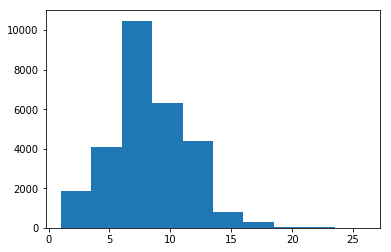

In [25]:
A = [len(t) for t in set(flatten_lol(tokens))]
plt.hist(A)
print(min(A))
B = [t for t in set(flatten_lol(tokens)) if len(t)<4]
#print(B)
#for b in B:
#    if b in stopwords:
#        print(b)

In [26]:
print('k' in set(flatten_lol(tokens)))

True


In [27]:
print('Number of documents:',len(tokens), '. Average nb of tokens in all documents:', 
      np.mean([len(ii) for ii in tokens]))

Number of documents: 22617 . Average nb of tokens in all documents: 752.7533713578282


In [28]:
t0 = time.time()
if REMOVE:
    tags = [nltk.pos_tag(elem) for elem in tokens2]
    print('Done - removing the stopwords')
else:
    tags = [nltk.pos_tag(elem) for elem in tokens]
print_elapsed(t0, task = 'tagging all elements in NOS tokens')

Done with tagging all elements in NOS tokens. Elapsed time: 594.982032


In [29]:
nltk.pos_tag(['get','write'])

[('get', 'VB'), ('write', 'JJ')]

In [30]:
if REMOVE:
    df_nos['tokens'] = tokens2
else:
    df_nos['tokens'] = tokens
df_nos['tagged_tokens'] = tags

In [31]:
t0 = time.time()
if pofs == 'n':
    select = [[word for word,pos in elem if (pos == 'NN' or pos == 'NNP')]
     for elem in tags]
elif pofs == 'v':
    select = [[word for word,pos in elem if (pos[0:2] == 'VB')]
     for elem in tags]
elif pofs == 'nv':
    select = [[word for word,pos in elem if (pos[0:2] in ['NN','VB'])]
     for elem in tags]
else:
    print('Wrong part of speech selected')
    raise ValueError
# manually remove "k"s and "p"s

print_elapsed(t0, task = 'retaining only nouns from NOS tokenization')


Done with retaining only nouns from NOS tokenization. Elapsed time: 3.109560


In [32]:
print('After keeping only the nouns. ''Number of documents:',len(select), '. Average nb of tokens in all documents:', 
      np.mean([len(ii) for ii in select]))
s = 'finance'
test = [elem for elem in select if s in elem]
print('Percentage of documents with the word {} in them: {:2.2f}%'.format(s,len(test)/len(select)*100))

After keeping only the nouns. Number of documents: 22617 . Average nb of tokens in all documents: 381.2338064287925
Percentage of documents with the word finance in them: 2.81%


In [33]:
print(test[0][0:20])
test = None

['develop', 'plan', 'area', 'responsibility', 'knowledge', 'k', 'principle', 'method', 'medium', 'term', 'planning', 'importance', 'creativity', 'innovation', 'planning', 'develop', 'assign', 'are', 'time', 'bound']


In [34]:
df_nos['pruned'] = select

In [35]:
LOAD = False
SAVE = True
if SAVE:
    # save the intermediate result: this contains all tokens that are names
    if REMOVE:
        qualifier = qualifier + '2'
    df_nos[['pruned', 'clean_full_text', 'tagged_tokens']].to_pickle(lookup_dir + 
                                                'all_nos_input_for_nlp_{}_pruned_{}.zip'.format(qualifier,pofs))
    with open(lookup_dir + 'stopwords_for_nos_{}_{}.pickle'.format(qualifier,pofs),'wb') as f:
        pickle.dump((stopwords, no_idea_why_here_stopwords, more_stopwords), f)
if LOAD:
    # load it if needs be
    df_nos = df_nos.join(pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}_pruned_{}.zip'.format(
                                        qualifier,pofs)))

